In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

In [64]:
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(interval='1d',start='2017-4-1',end='2022-6-1',)
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03 00:00:00-04:00,33.768534,33.864872,33.613448,33.766182,79942800,0.0,0.0
2017-04-04 00:00:00-04:00,33.660450,34.045812,33.641652,34.017616,79565600,0.0,0.0
2017-04-05 00:00:00-04:00,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0
2017-04-06 00:00:00-04:00,33.904819,33.958867,33.707440,33.756786,84596000,0.0,0.0
2017-04-07 00:00:00-04:00,33.773232,33.878971,33.665145,33.681591,66688800,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-24 00:00:00-04:00,140.381795,141.538271,136.912382,139.933167,104132700,0.0,0.0
2022-05-25 00:00:00-04:00,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0
2022-05-26 00:00:00-04:00,136.972191,143.901053,136.722951,143.342758,90601500,0.0,0.0


In [54]:
#tickerDfResample = pd.DataFrame(tickerDf.resample('W').sum())
#tickerDfResample[tickerDfResample == 0] = None
#tickerDfResample = tickerDfResample.interpolate(method='linear')
#tickerDfResample.index = pd.to_datetime(tickerDfResample.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
#tickerDfResample
tickerDfResample = tickerDf
#tickerDfResample = tickerDfResample.reset_index()

In [55]:
tickerDfResample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2017-04-03 00:00:00-04:00 to 2022-05-31 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1300 non-null   float64
 1   High          1300 non-null   float64
 2   Low           1300 non-null   float64
 3   Close         1300 non-null   float64
 4   Volume        1300 non-null   int64  
 5   Dividends     1300 non-null   float64
 6   Stock Splits  1300 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 81.2 KB


In [56]:
first_diff = tickerDfResample.Close.values[1:]-tickerDfResample.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDfResample['FirstDifference'] = first_diff
tickerDfResample['PercentageChange'] = tickerDfResample.Close.pct_change().fillna(0) #  "by what percentage did previous value change to get to current value"current value - previous value / previous value = pct change
tickerDfResample

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference,PercentageChange
Date,,,,,,,,,
2017-04-03 00:00:00-04:00,33.768542,33.864879,33.613456,33.766190,79942800,0.0,0.0,0.251434,0.000000
2017-04-04 00:00:00-04:00,33.660458,34.045820,33.641659,34.017624,79565600,0.0,0.0,-0.176247,0.007446
2017-04-05 00:00:00-04:00,33.888372,34.179745,33.792031,33.841377,110871600,0.0,0.0,-0.084579,-0.005181
2017-04-06 00:00:00-04:00,33.904831,33.958878,33.707451,33.756798,84596000,0.0,0.0,-0.075207,-0.002499
2017-04-07 00:00:00-04:00,33.773232,33.878971,33.665145,33.681591,66688800,0.0,0.0,-0.039944,-0.002228
...,...,...,...,...,...,...,...,...,...
2022-05-24 00:00:00-04:00,140.381810,141.538287,136.912397,139.933182,104132700,0.0,0.0,0.159515,-0.019216
2022-05-25 00:00:00-04:00,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0,3.250076,0.001140
2022-05-26 00:00:00-04:00,136.972206,143.901068,136.722966,143.342773,90601500,0.0,0.0,5.842178,0.023199


In [57]:
(34.017609 - 33.766190 )/ 33.76619

0.007445880035621386

In [58]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P_value: ",dftest[1])
    print("3. num_lags: ",dftest[2])
    print("4. : ",dftest[3])
    print("5. crit_value: ",dftest[4])
    for key,val in dftest[4].items():
        print("\t",key,": ",val)

In [59]:
ad_test(tickerDfResample['PercentageChange'])

1. ADF:  -11.394695038494335
2. P_value:  7.910880836428414e-21
3. num_lags:  8
4. :  1291
5. crit_value:  {'1%': -3.4354254066484664, '5%': -2.863781366113082, '10%': -2.56796331977745}
	 1% :  -3.4354254066484664
	 5% :  -2.863781366113082
	 10% :  -2.56796331977745


In [60]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [61]:
stepwise_fit = auto_arima(tickerDfResample['Close'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5313.795, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5313.431, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5309.023, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5308.897, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5314.327, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5310.616, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5310.782, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5312.582, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5310.265, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.431 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1300
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2651.449
Date:                Tue, 24 Jan 2023   AIC                           5308.897
Time:                        15:38:28   BIC                           5324.406
Sample:                             0   HQIC                          5314.716
                               - 1300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0882      0.048      1.833      0.067      -0.006       0.183
ma.L1         -0.0717      0.017     -4.106      0.000      -0.106      -0.037
sigma2         3.4708      0.072     48.115      0.000       3.329       3.612
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1453.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              15.46   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

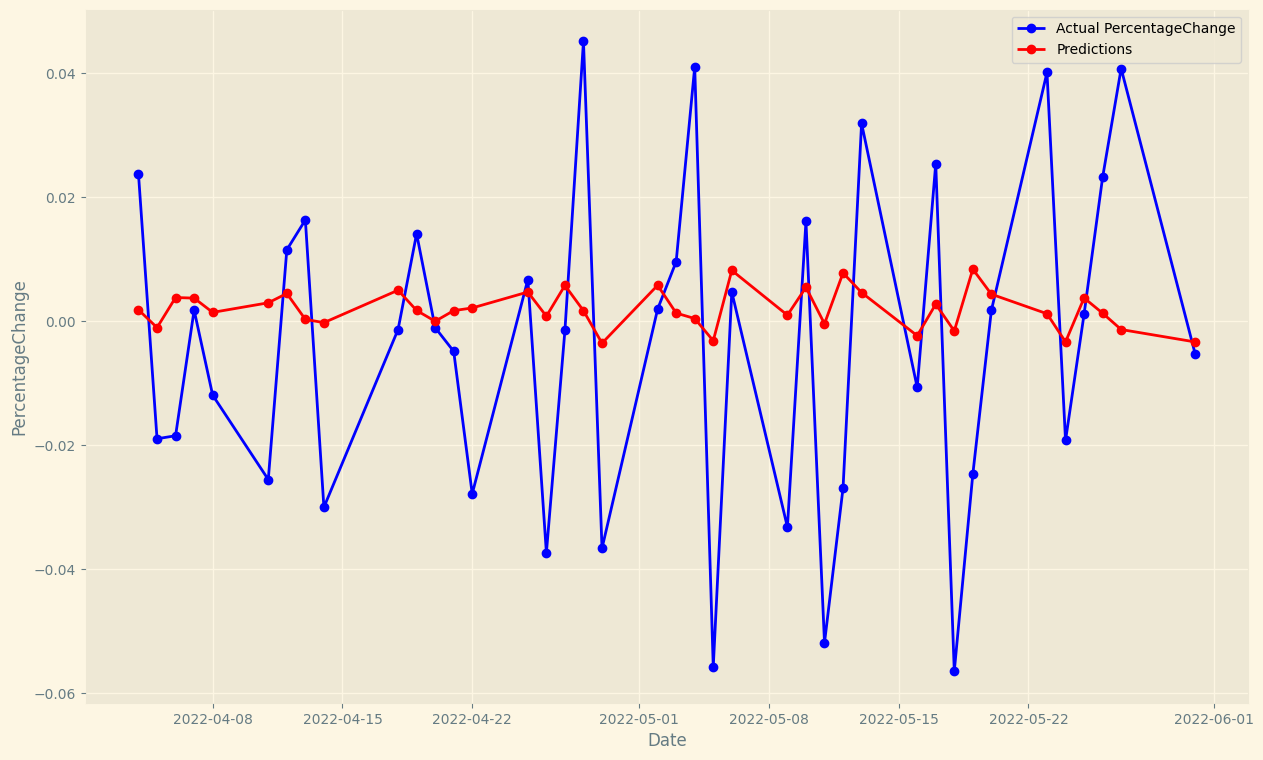

In [35]:
# percentage change prediction
trainData = tickerDfResample['PercentageChange'][0:1260]
testData = pd.DataFrame(tickerDfResample['PercentageChange'][1260:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = ARIMA(trainData,order=(1,0,0))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast()
    
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['PercentageChange'][i:i+1])

#plot for percentage change prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(testData['PercentageChange'],'-bo',label='Actual PercentageChange')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("PercentageChange")
plt.show()
 

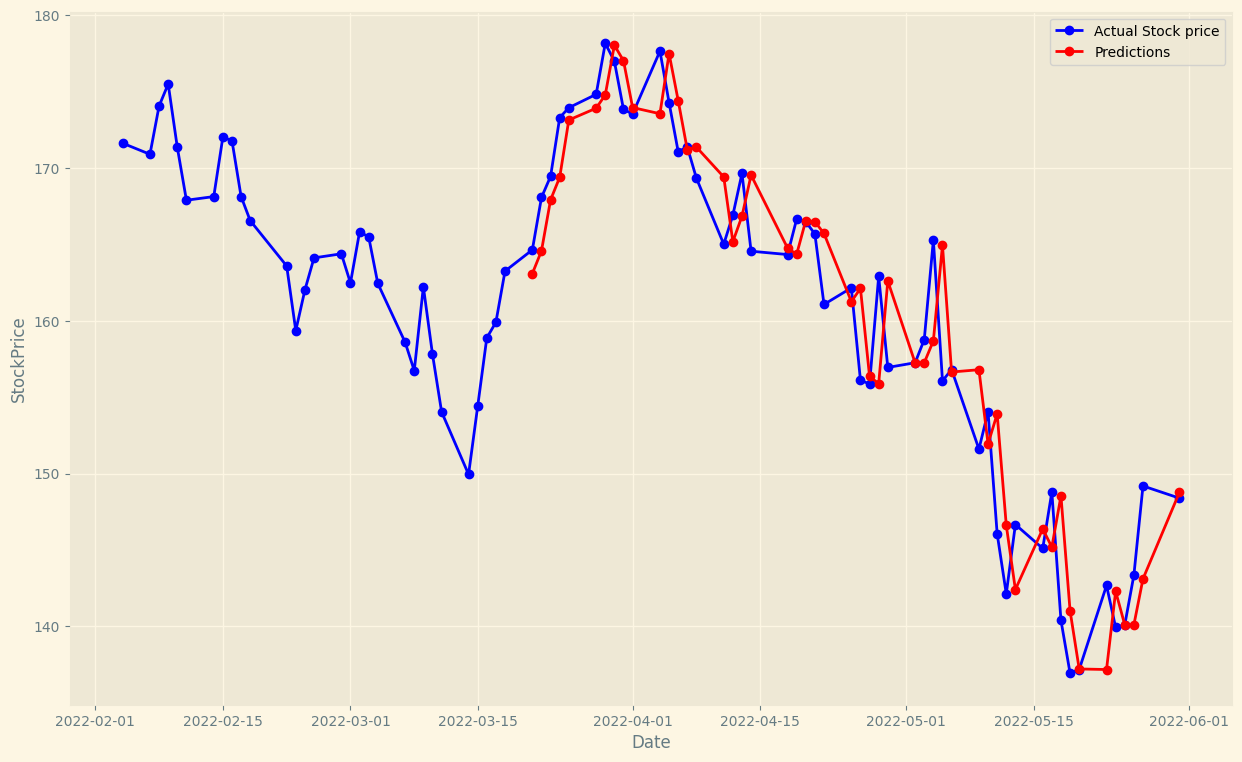

In [62]:
#close price prediction
trainData = tickerDfResample['Close'][0:1250]
testData = pd.DataFrame(tickerDfResample['Close'][1250:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = ARIMA(trainData,order=(0,1,1))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast()
   # futureForcast = np.mean(futureForcast)
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1220:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show() 

In [65]:
#Fbprophet prediction
df = pd.DataFrame(tickerDfResample['Close'][0:1250]).reset_index()
df.columns = ['ds','y']
df['ds'] = df['ds'].dt.tz_localize(None)
testData = pd.DataFrame(tickerDfResample['Close'][1250:])

model = Prophet()
model.fit(df)

15:46:32 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing


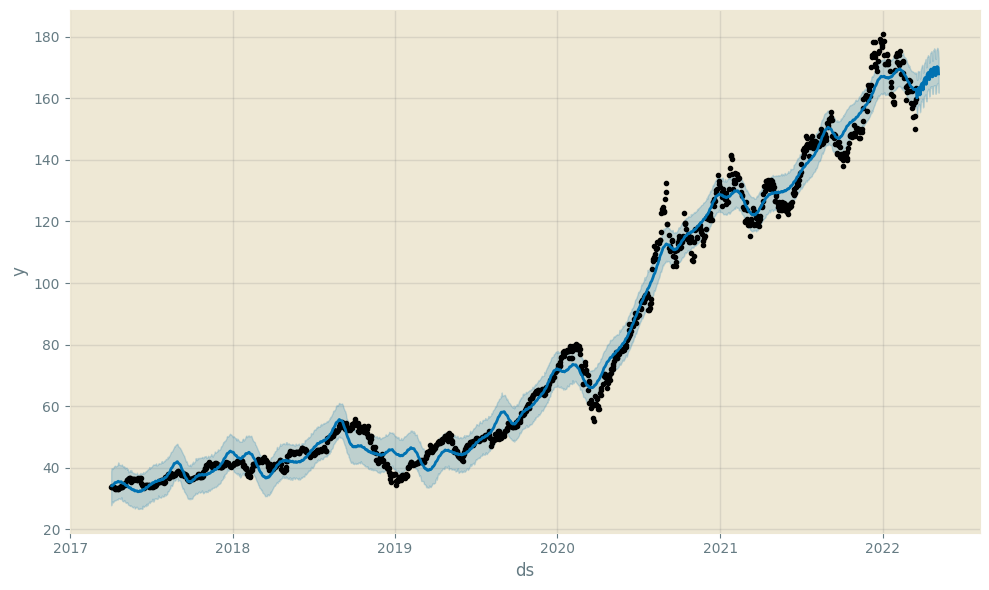

In [66]:
futureDates = model.make_future_dataframe(periods = 50)
prediction = model.predict(futureDates)
fig = model.plot(prediction)